In [45]:
import pandas as pd
!pip3 install -q matplotlib
!pip3 install -q seaborn
!pip3 install -q scikit-learn
!pip3 install -q numdifftools
import scipy.optimize as spop
from scipy.optimize import minimize, Bounds
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import t
from numdifftools import Hessian
from matplotlib.ticker import MultipleLocator
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


*In the following line of code, select the symbol (XBT: Bitcoin, XET: Ethereum, XAU: Gold, USOUSD: Crude Oil) for which you want to obtain the in-sample and out-of-sample results of our Results section.*

In [46]:
symbol = 'XBT' #XBT, XET, XAU, USOUSD
data = pd.read_csv(f'{symbol}_FINAL_NEW.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
starting_date = pd.to_datetime("2023-01-04")
ending_date = pd.to_datetime("2024-11-29")
data = data[data['datetime'] >= starting_date] #to allign dates of XBT, XET, XAU and USOUSD
data = data[data['datetime'] <= ending_date]

In [47]:
def adf_test(series, column_name):
    result = adfuller(series, autolag='AIC')  # Let the function choose the best lag with AIC
    print(f'Results of Augmented Dickey-Fuller Test for {column_name}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[0] < result[4]["5%"]:
        print(f"The {column_name} series is stationary.")
    else:
        print(f"The {column_name} series is not stationary.")


adf_test(data['returns'], 'returns')
adf_test(data['iv_returns'], 'iv_returns')

Results of Augmented Dickey-Fuller Test for returns
ADF Statistic: -17.550650
p-value: 0.000000
Critical Values:
	1%: -3.4398077121659765
	5%: -2.865713608066101
	10%: -2.5689925469026402
The returns series is stationary.
Results of Augmented Dickey-Fuller Test for iv_returns
ADF Statistic: -10.339433
p-value: 0.000000
Critical Values:
	1%: -3.439876604020831
	5%: -2.8657439615125675
	10%: -2.5690087183208665
The iv_returns series is stationary.


Text(0.5, 1.0, 'iv_returns')

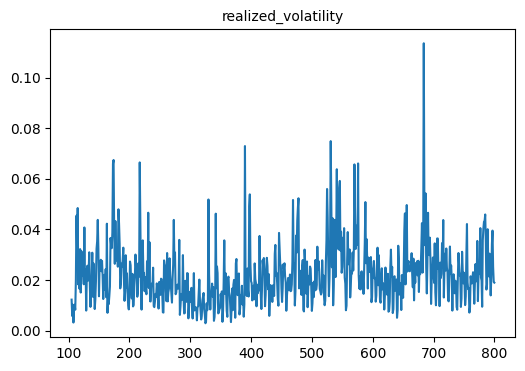

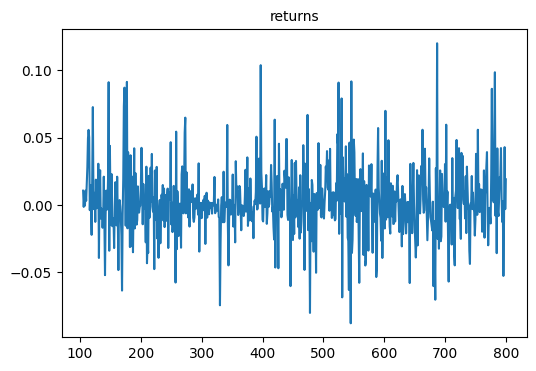

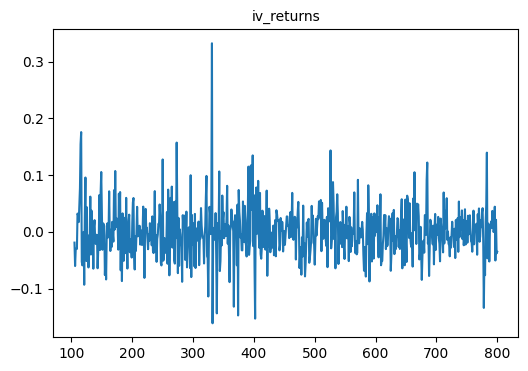

In [48]:
plt.figure(figsize=(6,4))
plt.plot(data['realized_volatility'])
plt.title('realized_volatility', fontsize=10)

plt.figure(figsize=(6,4))
plt.plot(data['returns'])
plt.title('returns', fontsize=10)

plt.figure(figsize=(6,4))
plt.plot(data['iv_returns'])
plt.title('iv_returns', fontsize=10)

In [49]:
data['returns'] = data['returns']*100 # rescaling
data['iv_returns'] = data['iv_returns']*100
data['realized_volatility'] = data['realized_volatility']*100
data['realized_volatility_t-1'] = data['realized_volatility_t-1']*100
data['implied_volatility'] = data['implied_volatility']*100



In [50]:
split = pd.to_datetime("2024-07-13") # ~80% in-sample, 20% out-of-sample


data['datetime'] = pd.to_datetime(data['datetime'])
train  = data[data['datetime'] < split]
test = data[data['datetime'] >= split]
returns = train['returns'].to_numpy()
realized_volatility = train['realized_volatility'].to_numpy()
iv_returns = train['iv_returns'].to_numpy()

Predictions and Out-of-Sample Analysis

In [51]:
#Naive Predictions
x = data['datetime'].loc[data['datetime'] >= split] 
naive_pred = test['realized_volatility_t-1']
real = test['realized_volatility']
rmse = np.sqrt(mean_squared_error(real,naive_pred))
mae = (mean_absolute_error(real,naive_pred))
print("NAIVE: ")
print("RMSE: ", rmse, "MAE: ", mae)

NAIVE: 
RMSE:  1.3949158632044887 MAE:  0.9571242672561391


**GARCH-IV Implementation**

To fit and test every model combination for the chosen asset, you must alter the flags (namely include_iv, garch_flag, egarch_flag, and gjr_garch_flag) found in the Lines 144-147.

The regression models (REGR(model type, IV) as named in our paper) run automatically alongside with the plain garch-type models, every time include_iv = False and the corresponding model type flag is assigned the True value (e.g. garch_flag = True, will run and test the plain GARCH and the REGR(GARCH,IV) models).

To fit and test our proposed augmented with an IV parameter models, you have to set the include_iv = True together with the model's flag (e.g. to test the GARCH-IV model you have to set the flags: include_iv = True, garch_flag = True and leave the rest with the False value assigned to them).

Model parameters
[ 0.18031008  1.08260568  0.14978963 -0.19545395  0.61171907]

mu 0.18031
omega 1.082606
alpha 0.1498
beta -0.1955
theta 0.6117
log-likelihood -1271.2501
SE of parameters [0.09679216 0.98141123 0.05781592 0.13532235 0.16965931], p-values: [0.06301412 0.27046044 0.00982884 0.14920662 0.00033973]


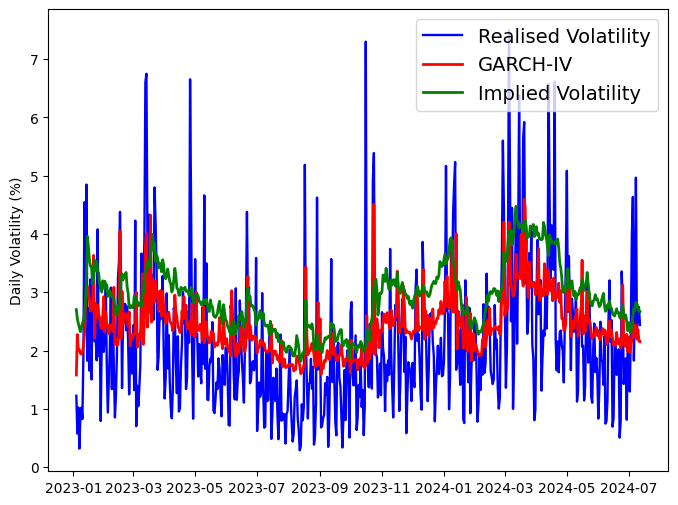

last GARCH forecast entry 2.1533168131300444
last IV forecast entry 2.66672880967394


In [52]:
def calculate_pi(initial_params, params, returns, log_likehood, n):
    hessian = Hessian(model_wrapper)
    H = hessian(params)
    #print(H)
    cov_matrix = np.linalg.inv(H)  # Invert Hessian to get covariance matrix
    standard_errors = np.sqrt(np.diag(cov_matrix))
    t_stats = params / standard_errors
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - len(initial_params)))
    return standard_errors, t_stats, p_values


def garch_iv(params, returns, iv_returns):
    #specifying model parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    theta = params[4]
    returns = returns
    iv_returns = iv_returns
    #calculating long-run volatility
    long_run = (omega/(1 - alpha - beta - theta))**(1/2)
    #calculating realised and conditional volatility
    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] =  long_run
    for t in range(1,len(returns)):
        conditional[t] = np.sqrt(omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2 + theta*iv_returns[t-1]**2)
    #calculating log-likelihood
    likelihood = (1/((2*np.pi)**(1/2)*conditional))*np.exp(-realised**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood


def garch(params, returns):
    #specifying model parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    returns = returns
    #calculating long-run volatility
    long_run = np.sqrt((omega/(1 - alpha - beta)))
    #calculating realised and conditional volatility
    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] =  long_run
    for t in range(1,len(returns)):
        conditional[t] = np.sqrt(omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)
    #calculating log-likelihood
    likelihood = (1/((2*np.pi)**(1/2)*conditional))*np.exp(-realised**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood


def egarch(params, returns, iv_returns, flag):
    #specifying model parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    gamma = params[4]  # Asymmetric effect
    if flag == True:
        iv_returns = iv_returns
        theta = params[5]
    returns = returns
    resid = returns - mu
    log_sigma2 = np.zeros(len(returns))
    log_sigma2[0] = np.log(np.var(returns))
    
    testing = []

    for t in range(1,len(returns)):
        abs_norm_resid = np.abs(resid[t-1]) / np.sqrt(np.exp(log_sigma2[t-1]))
        norm_resid = resid[t-1] / np.sqrt(np.exp(log_sigma2[t-1]))
        testing.append(np.sqrt(np.exp(log_sigma2[t-1])))
        if flag == False:
            log_sigma2[t] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_sigma2[t-1]
        if flag == True:
            log_sigma2[t] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_sigma2[t-1] + theta*np.log(iv_returns[t-1]**2)
    conditional_sigma2 = np.exp(log_sigma2)
    likelihood = (1 / (np.sqrt(2 * np.pi * conditional_sigma2))) * np.exp(-resid**2 / (2 * conditional_sigma2))
    log_likelihood = np.sum(np.log(likelihood))

    #plt.figure(figsize=(8,6))
    #plt.title(f'In-Sample Volatility Modeling for {symbol.upper()}', fontsize=10)
    #plt.ylabel('values')
    #plt.gca().yaxis.set_major_locator(MultipleLocator(0.50))
    #plt.xticks(fontsize=10)
    #plt.plot(x_train[1:], testing, color='blue', linewidth=1.7)

    return -log_likelihood


def gjr_garch(params, returns, iv_returns, flag):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    gamma = params[4]
    if flag == True:
        iv_returns = iv_returns
        theta = params[5]    
    resid = returns - mu  # This computes the residuals, ε_t-1
    conditional = np.zeros(len(returns))
    conditional[0] = (omega / (1 - alpha - beta - 0.5 * gamma))**(1/2)

    for t in range(1, len(returns)):
        indicator = 1 if resid[t-1] < 0 else 0  # This is the indicator function I{ε_t-1 < 0}
        if flag == False:
            conditional[t] = omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1]
        if flag == True:
            conditional[t] = omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1] + theta*iv_returns[t-1]**2

    likelihood = (1 / (np.sqrt(2 * np.pi * conditional))) * np.exp(-resid**2 / (2 * conditional))
    log_likelihood = np.sum(np.log(likelihood))
    
    return -log_likelihood


def model_wrapper(params):
    if include_iv == False and garch_flag == True:
        return garch(params, returns)
    elif include_iv == True and garch_flag == True:
        return garch_iv(params, returns, iv_returns)
    elif egarch_flag == True:
        return egarch(params, returns, iv_returns, include_iv)
    elif gjr_garch_flag == True:
        return gjr_garch(params, returns, iv_returns, include_iv)


################################
split = "2024-07-13" 
train  = data[data['datetime'] < split]
n = train.shape[0]
test = data[data['datetime'] >= split]
realized_volatility = train['realized_volatility'].to_numpy()
x = data['datetime'].loc[data['datetime'] >= split]
x_train =  data['datetime'].loc[data['datetime'] < split]
################################
model_name = 'GARCH-IV'
include_iv = True
garch_flag = True
egarch_flag = False
gjr_garch_flag = False
###############################

#starting parameter values - returns, sample mean and variance
returns = train['returns'].to_numpy()
#iv_returns = train['implied_volatility'].to_numpy()
iv_returns = train['implied_volatility'].to_numpy()
mean = np.average(returns)
var = np.std(returns)**2
#maximising log-likelihood
if (include_iv == True) and (garch_flag == True):
    initial_params = [mean, var, 0.1, 0.65, 0.1]
    #bounds = Bounds([0, 0, 0, 0, 0], [np.inf, np.inf, 1, 1, 1])
    res = spop.minimize(garch_iv, initial_params, args = (returns, iv_returns), method='Nelder-Mead')
    params = res.x
    mu = res.x[0]
    omega = res.x[1]
    alpha = res.x[2]
    beta = res.x[3]
    theta = res.x[4]
    long_run = (omega/(1 - alpha - beta - theta))**(1/2)
    log_likelihood = -float(res.fun)
    standard_errors, t_stats, p_values = calculate_pi(initial_params, params, returns,log_likelihood, n)

if (include_iv == False) and (garch_flag == True):
    initial_params = [mean, var, 0.1, 0.65]
    res = spop.minimize(garch, initial_params, args = (returns), method='Nelder-Mead')
    params = res.x
    mu = res.x[0]
    omega = res.x[1]
    alpha = res.x[2]
    beta = res.x[3]
    long_run = np.sqrt((omega/(1 - alpha - beta)))
    log_likelihood = -float(res.fun)
    standard_errors, t_stats, p_values = calculate_pi(initial_params, params, returns,log_likelihood, n)

if (egarch_flag == True):
    if include_iv == True:
        initial_params = [mean, var, 0.1, 0.65, -0.1, 0.1]
    else:
        initial_params = [mean, var, 0.1, 0.65, -0.1]
    res = spop.minimize(egarch, initial_params, args = (returns, iv_returns, include_iv) , method='Nelder-Mead')
    params = res.x
    mu = res.x[0]
    omega = res.x[1]
    alpha = res.x[2]
    beta = res.x[3]
    gamma = res.x[4]
    if include_iv == True:
        theta = res.x[5]
    log_likelihood = -float(res.fun)
    standard_errors, t_stats, p_values = calculate_pi(initial_params, params, returns,log_likelihood, n)


if (gjr_garch_flag == True):
    if include_iv == True:
        initial_params = [mean, var, 0.1, 0.65, -0.1, 0.1]
    else:
        initial_params = [mean, var, 0.1, 0.65, -0.1]
    res = spop.minimize(gjr_garch, initial_params, args = (returns, iv_returns, include_iv) , method='Nelder-Mead')
    params = res.x
    mu = res.x[0]
    omega = res.x[1]
    alpha = res.x[2]
    beta = res.x[3]
    gamma = res.x[4]
    if include_iv == True:
        theta = res.x[5]
    log_likelihood = -float(res.fun)
    standard_errors, t_stats, p_values = calculate_pi(initial_params, params, returns,log_likelihood, n)

#############################
#printing optimal parameters
print('Model parameters')
print(params)
print('')
print('mu '+str(round(mu, 6)))
print('omega '+str(round(omega, 6)))
print('alpha '+str(round(alpha, 4)))
print('beta '+str(round(beta, 4)))
if (egarch_flag == True) or (gjr_garch_flag == True):
    print('gamma '+str(round(gamma, 4)))
if (include_iv == True):
    print('theta '+str(round(theta, 4)))
#print('long-run volatility '+str(round(long_run, 4)))
print('log-likelihood '+str(round(log_likelihood, 4)))
print(f'SE of parameters {standard_errors}, p-values: {p_values}')

if garch_flag == True:
    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] =  long_run
    for t in range(1,len(returns)):
        if include_iv == True:
            conditional[t] = np.sqrt(omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2 + theta*iv_returns[t-1]**2)
        if include_iv == False:
            conditional[t] = np.sqrt(omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)
if egarch_flag == True:
    resid = returns - mu
    log_sigma2 = np.zeros(len(returns))
    log_sigma2[0] = np.log(np.var(returns))
    conditional = np.zeros(len(returns))
    conditional[0] = np.sqrt(np.exp(np.log(np.var(returns))))
    for t in range(1,len(returns)):
        abs_norm_resid = np.abs(resid[t-1]) / np.sqrt(np.exp(log_sigma2[t-1]))
        norm_resid = resid[t-1] / np.sqrt(np.exp(log_sigma2[t-1]))
        if include_iv == False:
            log_sigma2[t] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_sigma2[t-1]
            conditional[t] = np.sqrt(np.exp(log_sigma2[t]))
        if include_iv == True:
            log_sigma2[t] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_sigma2[t-1] + theta*np.log(iv_returns[t-1]**2)
            conditional[t] = np.sqrt(np.exp(log_sigma2[t]))

if gjr_garch_flag == True:
    resid = returns - mu
    conditional = np.zeros(len(returns))
    conditional[0] = (omega / (1 - alpha - beta - 0.5 * gamma))**(1/2)
    for t in range(1,len(returns)):
        indicator = 1 if resid[t-1] < 0 else 0
        if include_iv == False:
            conditional[t] = np.sqrt(omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1]**2)
        if include_iv == True:
            conditional[t] = np.sqrt(omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1]**2 + theta*iv_returns[t-1]**2)


####### FOR QUICK PLOTING ONLY #########
# change for every best model configuration
'''
model_2 = 'GJR-GARCH'
include_iv = False
garch_flag = False
egarch_flag = False
gjr_garch_flag = True
returns = train['returns'].to_numpy()
iv_returns = train['implied_volatility'].to_numpy()
mean = np.average(returns)
var = np.std(returns)**2
if (gjr_garch_flag == True):
    if include_iv == True:
        initial_params = [mean, var, 0.1, 0.65, -0.1, 0.1]
    else:
        initial_params = [mean, var, 0.1, 0.65, -0.1]
    res = spop.minimize(gjr_garch, initial_params, args = (returns, iv_returns, include_iv) , method='Nelder-Mead')
    params = res.x
    mu = res.x[0]
    omega = res.x[1]
    alpha = res.x[2]
    beta = res.x[3]
    gamma = res.x[4]
    if include_iv == True:
        theta = res.x[5]
    log_likelihood = -float(res.fun)
    #standard_errors, t_stats, p_values = calculate_pi(initial_params, params, returns,log_likelihood, n)

if gjr_garch_flag == True:
    resid = returns - mu
    conditional_2 = np.zeros(len(returns))
    conditional_2[0] = (omega / (1 - alpha - beta - 0.5 * gamma))**(1/2)
    for t in range(1,len(returns)):
        indicator = 1 if resid[t-1] < 0 else 0
        if include_iv == False:
            conditional_2[t] = np.sqrt(omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1]**2)
        if include_iv == True:
            conditional_2[t] = np.sqrt(omega + alpha * resid[t-1]**2 + gamma * resid[t-1]**2 * indicator + beta * conditional[t-1]**2 + theta*iv_returns[t-1]**2)
'''
#######################################
#'''
#from matplotlib.ticker import MultipleLocator
#visualising the results
plt.figure(figsize=(8,6))
#plt.title(f'In-Sample Volatility Modeling for {symbol.upper()}', fontsize=10)
plt.ylabel('Daily Volatility (%)')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.xticks(fontsize=10)
plt.plot(x_train,realized_volatility, color='blue', linewidth=1.7)
#plt.plot(train.index,realised, color='purple')
#plt.plot(train.index,returns, color='green')
#plt.plot(x_train, log_sigma2, color='black', linewidth=2)
plt.plot(x_train,conditional, color='red', linewidth=2)
#plt.plot(x_train,conditional_2, color='orange', linewidth=2)
plt.plot(x_train,iv_returns, color='green', linewidth=2)
plt.legend(['Realised Volatility', f'{model_name}', 'Implied Volatility'], fontsize=14, loc="upper right")
#plt.legend(['Realised Volatility', f'{model_name}', f'{model_2}','Implied Volatility'], fontsize=7, loc="upper right")

# Hide the first x-axis tick label
#plt.gca().xaxis.get_major_ticks()[0].label1.set_visible(False)
plt.show()
print("last GARCH forecast entry", conditional[-1])
print("last IV forecast entry",iv_returns[-1])
#'''
last = conditional[-1]
last_resid = resid[-1]
last_iv = iv_returns[-1]

#################################
# Ensembled Regression Training # (valid when flag include_iv == False)
#################################
if include_iv == False:
    garch_forecasts = conditional**2
    iv_forecasts = iv_returns**2
    realized_volatility_squared = realized_volatility**2
    d = {"garch_forecasts": garch_forecasts, "iv_forecasts": iv_forecasts, "realized_volatility_squared": realized_volatility_squared}
    df_reg = pd.DataFrame(d)
    df_reg['iv_forecasts'] = df_reg['iv_forecasts'].shift(1)
    df_reg.dropna(inplace=True)
    #print(df_reg)
    X = df_reg[['garch_forecasts', 'iv_forecasts']]
    X = sm.add_constant(X)
    # Dependent variable
    y = df_reg['realized_volatility_squared']

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(model.summary())
    # hypothesis tests
    # H0: a1 = 0 (GARCH does not add information beyond IV)
    # H0: a2 = 0 (IV does not add information beyond GARCH and RV)

    # Use t-tests from the model summary
    t_test_garch = model.t_test('garch_forecasts = 0')
    t_test_iv = model.t_test('iv_forecasts = 0')

    # Print the coefficients for garch_forecasts and iv_forecasts
    print("\nCoefficients:")
    print("Intercept:", model.params['const'])
    print("GARCH forecasts:", model.params['garch_forecasts'])
    print("IV forecasts:", model.params['iv_forecasts'])




In [53]:
## quick plotting ##
'''
y_pred = model.predict(X)  # fitted values
plt.figure(figsize=(8,6))
#plt.title(f'In-Sample Volatility Modeling for {symbol.upper()}', fontsize=10)
plt.ylabel('Daily Volatility (%)')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.xticks(fontsize=10)
plt.plot(x_train[1:],realized_volatility[1:], color='blue', linewidth=1.7)
#plt.plot(train.index,realised, color='purple')
#plt.plot(train.index,returns, color='green')
#plt.plot(x_train, log_sigma2, color='black', linewidth=2)
plt.plot(x_train[1:],y_pred, color='red', linewidth=2)
plt.plot(x_train[1:],conditional_2[1:], color='orange', linewidth=2)
plt.plot(x_train[1:],iv_returns[1:], color='green', linewidth=2)
plt.legend(['Realised Volatility', f'{model_name}', 'Implied Volatility'], fontsize=14, loc="upper right")
plt.legend(['Realised Volatility', f'{model_name}', f'{model_2}','Implied Volatility'], fontsize=7, loc="upper right")

# Hide the first x-axis tick label
#plt.gca().xaxis.get_major_ticks()[0].label1.set_visible(False)
plt.show()
'''

'\ny_pred = model.predict(X)  # fitted values\nplt.figure(figsize=(8,6))\n#plt.title(f\'In-Sample Volatility Modeling for {symbol.upper()}\', fontsize=10)\nplt.ylabel(\'Daily Volatility (%)\')\nplt.gca().yaxis.set_major_locator(MultipleLocator(1))\nplt.xticks(fontsize=10)\nplt.plot(x_train[1:],realized_volatility[1:], color=\'blue\', linewidth=1.7)\n#plt.plot(train.index,realised, color=\'purple\')\n#plt.plot(train.index,returns, color=\'green\')\n#plt.plot(x_train, log_sigma2, color=\'black\', linewidth=2)\nplt.plot(x_train[1:],y_pred, color=\'red\', linewidth=2)\nplt.plot(x_train[1:],conditional_2[1:], color=\'orange\', linewidth=2)\nplt.plot(x_train[1:],iv_returns[1:], color=\'green\', linewidth=2)\nplt.legend([\'Realised Volatility\', f\'{model_name}\', \'Implied Volatility\'], fontsize=14, loc="upper right")\nplt.legend([\'Realised Volatility\', f\'{model_name}\', f\'{model_2}\',\'Implied Volatility\'], fontsize=7, loc="upper right")\n\n# Hide the first x-axis tick label\n#plt.gca

In [54]:
if include_iv == False:
    p_values_regr = model.pvalues
    print("P values Regression: ", p_values_regr)

Out-of-Sample Testing with Rolling Window Approach

In [55]:
#conditional = np.zeros(len(test))
#conditional[0] =  long_run
rolling_predictions = np.zeros(len(test))
regression_rolling_predictions = np.zeros(len(test))
log_rolling_predictions = np.zeros(len(test))
test_realized_volatility = test['realized_volatility'].to_numpy()
# last is the last estimation of volatility of the train set that is used for the first prediction of the test set
paper_trad = test
for i in range(len(test)):
    returns = data['returns'][:-(len(test)-i)].to_numpy()
    #iv_returns = data['implied_volatility'][:-(len(test)-i)].to_numpy()
    iv_returns = data['implied_volatility'][:-(len(test)-i)].to_numpy()
    mean = np.average(returns)
    var = np.std(returns)**2
    #maximising log-likelihood
    if garch_flag == True:
        if include_iv == True:
            initial_params = [mean, var, 0.1, 0.65, 0.1]
            res = spop.minimize(garch_iv, initial_params, args = (returns, iv_returns), method='Nelder-Mead')
            params = res.x
            mu = res.x[0]
            omega = res.x[1]
            alpha = res.x[2]
            beta = res.x[3]
            theta = res.x[4]
        if include_iv == False:
            initial_params = [mean, var, 0.1, 0.65]
            res = spop.minimize(garch, initial_params, args = (returns) , method='Nelder-Mead')
            params = res.x
            mu = res.x[0]
            omega = res.x[1]
            alpha = res.x[2]
            beta = res.x[3]
        resid = returns - mu
        realised = abs(resid)
        if i == 0:
            print(params)
            if include_iv == True:
                rolling_predictions[i] = np.sqrt(omega + alpha*last_resid**2 + beta*last**2 + theta*last_iv**2)
            else:
                rolling_predictions[i] = np.sqrt(omega + alpha*last_resid**2 + beta*last**2)
                # stuff for regression prediction 
                new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [last_iv**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
                df_reg = pd.concat([df_reg, new_row], ignore_index = True)
                X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_test = sm.add_constant(X_test)
                #print(len(X_test))
                y_reg_pred = model.predict(X_test).iloc[-1]
                regression_rolling_predictions[i] = np.sqrt(y_reg_pred)
                
                X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_train = sm.add_constant(X_train)
                # Dependent variable
                y_reg_real = df_reg['realized_volatility_squared']
                # Fit the regression model
                model = sm.OLS(y_reg_real, X_train).fit()

        else:
            if include_iv == True:
                rolling_predictions[i] = np.sqrt(omega + alpha*resid[i-1]**2 + beta*rolling_predictions[i-1]**2 + theta*iv_returns[i-1]**2)
            else:
                rolling_predictions[i] = np.sqrt(omega + alpha*resid[i-1]**2 + beta*rolling_predictions[i-1]**2)
                # stuff for regression prediction
                new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [iv_returns[i-1]**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
                df_reg = pd.concat([df_reg, new_row], ignore_index = True)
                X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_test = sm.add_constant(X_test)
                #print(len(df_reg))
                y_reg_pred = model.predict(X_test).iloc[-1]
                regression_rolling_predictions[i] = np.sqrt(y_reg_pred)

                X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_train = sm.add_constant(X_train)
                # Dependent variable
                y_reg_real = df_reg['realized_volatility_squared']
                # Fit the regression model
                model = sm.OLS(y_reg_real, X_train).fit()


    if egarch_flag == True:
        if include_iv == True:
            initial_params = [mean, var, 0.1, 0.65, -0.1, 0.1]
        else:
            initial_params = [mean, var, 0.1, 0.65, -0.1]
        res = spop.minimize(egarch, initial_params, args = (returns, iv_returns, include_iv), method='Nelder-Mead')
        params = res.x
        mu = res.x[0]
        omega = res.x[1]
        alpha = res.x[2]
        beta = res.x[3]
        gamma = res.x[4]
        if include_iv == True:
            theta = res.x[5]

        resid = returns - mu        
        if i == 0:
            norm_resid = last_resid / last
            abs_norm_resid = np.abs(last_resid) / last
            print(params)
            if include_iv == True:
                log_rolling_predictions[i] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * np.log(last**2) + theta*np.log(last_iv**2)    
            else:
                log_rolling_predictions[i] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * np.log(last**2)
            rolling_predictions[i] = np.sqrt(np.exp(log_rolling_predictions[i]))
            if include_iv == False:
                # stuff for regression prediction 
                new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [last_iv**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
                df_reg = pd.concat([df_reg, new_row], ignore_index = True)
                X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_test = sm.add_constant(X_test)
                #print(len(X_test))
                y_reg_pred = model.predict(X_test).iloc[-1]
                regression_rolling_predictions[i] = np.sqrt(y_reg_pred)
                
                X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_train = sm.add_constant(X_train)
                # Dependent variable
                y_reg_real = df_reg['realized_volatility_squared']
                # Fit the regression model
                model = sm.OLS(y_reg_real, X_train).fit()

        abs_norm_resid = np.abs(resid[i-1]) / np.sqrt(np.exp(log_rolling_predictions[i-1]))
        norm_resid = resid[i-1] / np.sqrt(np.exp(log_rolling_predictions[i-1]))
        if include_iv == False:
            log_rolling_predictions[i] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_rolling_predictions[i-1]
            rolling_predictions[i] = np.sqrt(np.exp(log_rolling_predictions[i]))
            # stuff for regression prediction
            new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [iv_returns[i-1]**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
            df_reg = pd.concat([df_reg, new_row], ignore_index = True)
            X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
            X_test = sm.add_constant(X_test)
            #print(len(df_reg))
            y_reg_pred = model.predict(X_test).iloc[-1]
            regression_rolling_predictions[i] = np.sqrt(y_reg_pred)

            X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
            X_train = sm.add_constant(X_train)
            # Dependent variable
            y_reg_real = df_reg['realized_volatility_squared']
            # Fit the regression model
            model = sm.OLS(y_reg_real, X_train).fit()
        if include_iv == True:
            log_rolling_predictions[i] = omega + alpha * (abs_norm_resid - np.sqrt(2/np.pi)) + gamma * norm_resid + beta * log_rolling_predictions[i-1] + theta*np.log(iv_returns[i-1]**2)
            rolling_predictions[i] = np.sqrt(np.exp(log_rolling_predictions[i]))



    if gjr_garch_flag == True:
        if include_iv == True:
            initial_params = [mean, var, 0.1, 0.65, -0.1, 0.1]
        else:
            initial_params = [mean, var, 0.1, 0.65, -0.1]
        res = spop.minimize(gjr_garch, initial_params, args = (returns, iv_returns, include_iv), method='Nelder-Mead')
        params = res.x
        mu = res.x[0]
        omega = res.x[1]
        alpha = res.x[2]
        beta = res.x[3]
        gamma = res.x[4]
        if include_iv == True:
            theta = res.x[5]
        resid = returns - mu
        if i == 0:
            print(params)
            #print(data['datetime'][:-(len(test)-i)].tail(5))
            #print(test.head(3))
            indicator = 1 if last_resid < 0 else 0
            if include_iv == True:
                rolling_predictions[i] = np.sqrt(omega + alpha * last_resid**2 + gamma * last_resid**2 * indicator + beta * last**2 + theta*last_iv**2)
            else:
                rolling_predictions[i] = np.sqrt(omega + alpha * last_resid**2 + gamma * last_resid**2 * indicator + beta * last**2)
                #print(rolling_predictions[i]**2)
                # stuff for regression prediction 
                new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [last_iv**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
                df_reg = pd.concat([df_reg, new_row], ignore_index = True)
                X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_test = sm.add_constant(X_test)
                #print(len(X_test))
                y_reg_pred = model.predict(X_test).iloc[-1]
                regression_rolling_predictions[i] = np.sqrt(y_reg_pred)
                
                X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_train = sm.add_constant(X_train)
                # Dependent variable
                y_reg_real = df_reg['realized_volatility_squared']
                # Fit the regression model
                model = sm.OLS(y_reg_real, X_train).fit()
            #print(X_train)
        else:
            indicator = 1 if resid[i-1] < 0 else 0
            if include_iv == True:
                rolling_predictions[i] = np.sqrt(omega + alpha * resid[i-1]**2 + gamma * resid[i-1]**2 * indicator + beta * rolling_predictions[i-1]**2 + theta*iv_returns[i-1]**2)
            else:
                rolling_predictions[i] = np.sqrt(omega + alpha * resid[i-1]**2 + gamma * resid[i-1]**2 * indicator + beta * rolling_predictions[i-1]**2)
                # stuff for regression prediction
                new_row = pd.DataFrame({"garch_forecasts": [rolling_predictions[i]**2], "iv_forecasts": [iv_returns[i-1]**2], "realized_volatility_squared": [test_realized_volatility[i]**2]})
                #print(rolling_predictions[i]**2)
                df_reg = pd.concat([df_reg, new_row], ignore_index = True)
                X_test = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_test = sm.add_constant(X_test)
                #print(len(df_reg))
                y_reg_pred = model.predict(X_test).iloc[-1]
                regression_rolling_predictions[i] = np.sqrt(y_reg_pred)

                
                X_train = df_reg[['garch_forecasts', 'iv_forecasts']]
                X_train = sm.add_constant(X_train)
                # Dependent variable
                y_reg_real = df_reg['realized_volatility_squared']
                # Fit the regression model
                model = sm.OLS(y_reg_real, X_train).fit()
                
            #if i == 1:
            #    print(data['datetime'][:-(len(test)-i)].tail(5))



    #data['pred_for_this_row'][i] = rolling_predictions[i]

rmse = np.sqrt(mean_squared_error(test['realized_volatility'][-len(test):],rolling_predictions))
rmse_numpy = np.sqrt(mean_squared_error(test_realized_volatility,rolling_predictions))
mae = (mean_absolute_error(test['realized_volatility'][-len(test):],rolling_predictions))
print("Out of Sample: ")
print("RMSE from dataframe: ", rmse, "MAE: ", mae)

if (include_iv == False):
    print("Regression Results")
    rmse = np.sqrt(mean_squared_error(test_realized_volatility,regression_rolling_predictions))
    mae = (mean_absolute_error(test_realized_volatility, regression_rolling_predictions))
    print("Out of Sample: ")
    print("RMSE", rmse, "MAE: ", mae)  

[ 0.18031008  1.08260568  0.14978963 -0.19545395  0.61171907]
Out of Sample: 
RMSE from dataframe:  1.2767977610982282 MAE:  0.8859698475045726
